In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
import scipy

import sys
sys.path.insert(1, '../')

import SpringRank_tools as sr
import tools as tl

%load_ext autoreload
%aimport SpringRank_tools
%aimport tools
%autoreload 1

%matplotlib inline

# Chess games

- 100 players
- 2 groups (white and black)
- Can change groups 

In [37]:
N = 100
beta = 0.1
alpha = 1 
K = 20
p_ij = 1 / (1 + np.exp(-2*beta))

variance = 1 / np.sqrt(alpha * beta)
individual_scores = np.random.normal(0, variance, N)

theta = np.array([0.5, 0]) # white gets +0.5 advantage

groups_1 = np.random.randint(0, 2, N)
G_1 = np.zeros((N, 2))
for j, g_j in enumerate(groups_1):
    G_1[j, g_j] = 1
    
ranks_1 = individual_scores + np.matmul(G_1, theta)    
    
G_2 = np.abs(G_1 - 1)
ranks_2 = individual_scores + np.matmul(G_2, theta)

In [38]:
Z_1 = 0
Z_2 = 0
scaled_energy_1 = np.zeros((N, N))
scaled_energy_2 = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        energy_1_ij = 0.5 * np.power(ranks_1[i] - ranks_1[j] - 1, 2)
        scaled_energy_1[i, j] =  np.exp(-beta * energy_1_ij)
        Z_1 += scaled_energy_1[i, j]
        
        energy_2_ij = 0.5 * np.power(ranks_2[i] - ranks_2[j] - 1, 2)
        scaled_energy_2[i, j] =  np.exp(-beta * energy_2_ij)
        Z_2 += scaled_energy_2[i, j]
c_1 = 20*N / Z_1
c_2 = 5*N / Z_2

A_1 = np.zeros((N, N))
A_2 = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        if i == j:
            continue
        A_1[i, j] = np.random.poisson(c_1 * scaled_energy_1[i, j])
        A_2[i, j] = np.random.poisson(c_2 * scaled_energy_2[i, j])

In [39]:
s_1 = sr.SpringRank(A_1)
s_2 = sr.SpringRank(A_2)

s_1 = tl.adjust_ranks(s_1, A_1)
s_2 = tl.adjust_ranks(s_2, A_2)

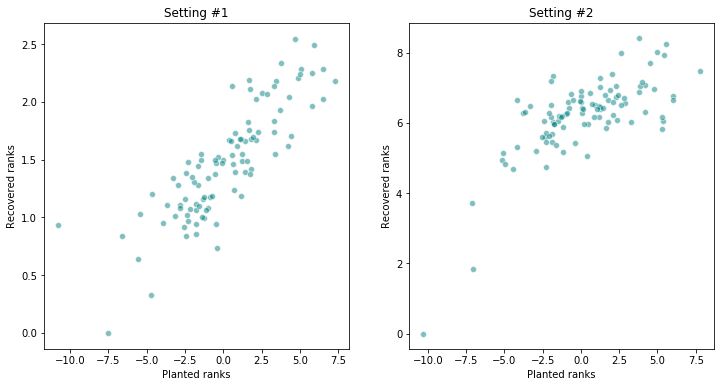

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(ranks_1, s_1, color="teal", edgecolor="white", alpha=0.5)
ax[0].set_xlabel("Planted ranks")
ax[0].set_ylabel("Recovered ranks")
ax[0].set_title("Setting #1")

ax[1].scatter(ranks_2, s_2, color="teal", edgecolor="white", alpha=0.5)
ax[1].set_xlabel("Planted ranks")
ax[1].set_ylabel("Recovered ranks")
ax[1].set_title("Setting #2")

plt.show()

In [41]:
group_diff = s_2 - s_1

result = LA.lstsq(G_2 - G_1, s_2 - s_1)
theta_est = result[0]

c:\python37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
theta_est - np.min(theta_est)

array([0.47648571, 0.        ])

In [45]:
a_1 = s_1 - np.matmul(G_1, theta_est)
a_2 = s_2 - np.matmul(G_2, theta_est)

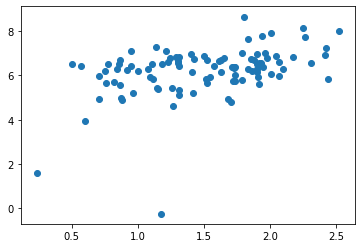

In [46]:
plt.scatter(a_1, a_2)